# White Mica Abundance Computation

This notebook seeks to identify and quantify absorption features related to the abundance of white mica using convex hull continuum removed data.

In [1]:
# import standard libaries
import os, warnings, subprocess
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# import gis libraries
import rasterio
from rasterio.windows import Window

# import key scipy modules
from scipy.interpolate import interp1d

# filter warnings for tidy output
warnings.filterwarnings("ignore")

In [8]:
# define a cloud optimised geotiff function that runs GDAL commands as subprocesses
def subprocess_to_cog(input_fn, resample='nearest'):
  # rename the input file
  tmp_fn = input_fn.replace('.tif', '_temporary.tif')
  cmd = 'mv %s %s'%(input_fn, tmp_fn)
  subprocess.call(cmd, shell=True)
  # save zoom levels
  cmd = 'gdaladdo -r %s %s 2 4 8 16'%(resample, tmp_fn)
  subprocess.call(cmd, shell=True)
  # convert to cloud optimised tif
  cmd = 'gdal_translate %s %s -co BIGTIFF=YES -co COMPRESS=LZW -co TILED=YES -co COPY_SRC_OVERVIEWS=YES'%(tmp_fn, input_fn)
  subprocess.call(cmd, shell=True)
  # remove temporary file
  subprocess.call('rm %s'%(tmp_fn), shell=True)

## 1. Toy Dataset 

Extract a 500 by 500 pixel window of the continuum removed data set and plot a random selection of responses around the white mica feature at 2200nm.

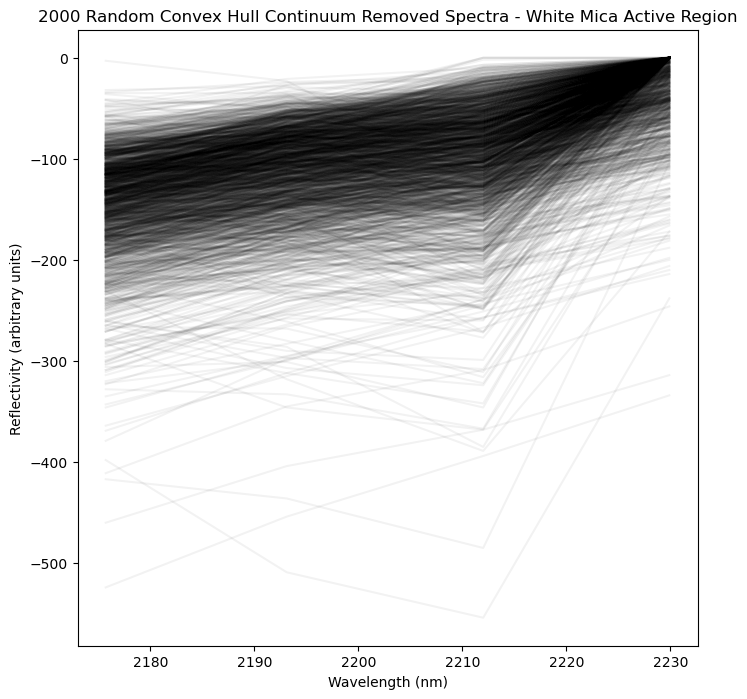

In [2]:
# set path to convex hull continuum removed ENVI grid
cvx_fn = r'/storage/gsq_hymap/outputs/GSQ_block-d_mosaic_hull.dat'

# read a 1500 by 1500 pixel window from the convex hull mosaics
read_win = Window(4000, 1500, 500, 500)
with rasterio.open(cvx_fn,'r') as src:
  pix_win = src.read(window=read_win)
  wvl = np.array([float(x.strip('nm')) for x in src.descriptions])

# get mask for wavelenghs in window 2170nm to 2250nm
key_wvl = (wvl>2160) * (wvl<2240)

# plot 2000 random spectra from the window spectra
fig, ax = plt.subplots(figsize=(8,8))
for i,j in zip(np.random.randint(0,500,2000), np.random.randint(0,500,2000)):
  ax.plot(wvl[key_wvl], pix_win[key_wvl,i,j], c='k', alpha=0.05)
ax.set(title='2000 Random Convex Hull Continuum Removed Spectra - White Mica Active Region',
  xlabel='Wavelength (nm)', ylabel='Reflectivity (arbitrary units)')
plt.show()

White micas typically have absorption features at about 2200nm. The relative depth of this feature can be used as a proxy for white mica abundance, while the position of the feature contains compositional information. We're going to use a simple quadratic function fitted to the spectrum in the window shown above to extract the depth and position information using the inflection point of the parabola. If this inflection point is outside of the window or the parabola is not U-shaped we return a null data pixel.

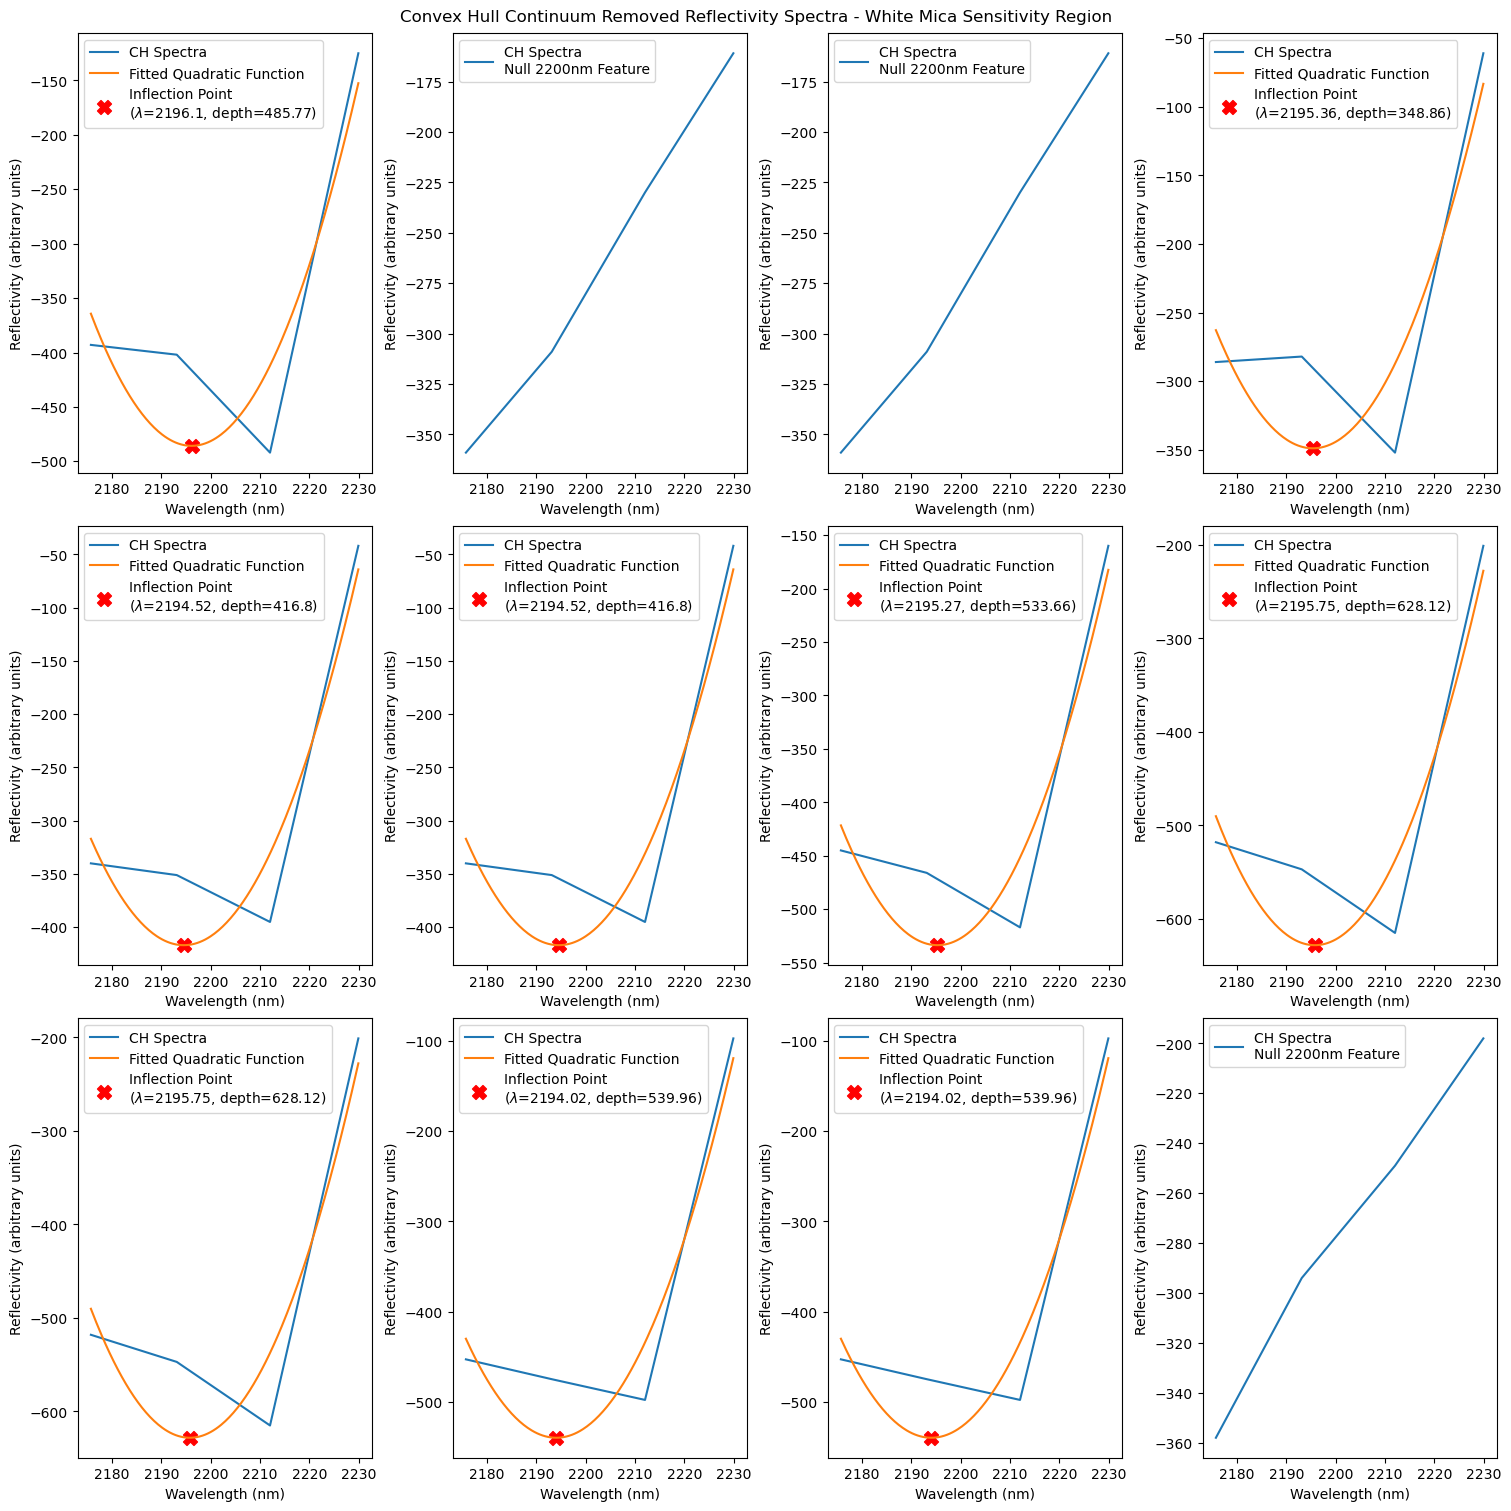

In [3]:
# get index of ~2200nm wavelenght
idx = np.argmin(abs(wvl-2200))

# select 12 pixels in the lowest 1 percentile reflectivity at ~2200 to demonstrate the workflow
pix_2d = pix_win.reshape((pix_win.shape[0], pix_win.shape[1] * pix_win.shape[2])).T
plot_pix = pix_2d[pix_2d[:,idx] < np.percentile(pix_2d[:,idx],1)][:12]

# loop through 12 random spectra from the window, fit a quadratic to the white mica wavlengths and plot
fig, axes = plt.subplots(3,4,figsize=(15,15), constrained_layout=True)
fig.suptitle('Convex Hull Continuum Removed Reflectivity Spectra - White Mica Sensitivity Region')
for ax, p in zip(axes.flatten(), plot_pix):
  # get the ~2200nm spectrum for the current pixel, get the corresponding wavelengths
  p = p[key_wvl].copy()
  w = wvl[key_wvl].copy()
  # create a temporary set of wavelengths for visualisation purposes
  nw = np.linspace(w.min(), w.max(), 200)
  # fit a quadratic function and get coefficients (ax^2 + bx + c)
  a, b, c = np.polyfit(w, p, 2)
  # calculate inflection point and inflection reflectivity
  ip = -b/(2*a)
  ipd = a*ip**2 + b*ip +c
  # if the inflection point is indide the window, plot some data
  if 2160 < ip < 2240 and a > 0:
    ax.plot(wvl[key_wvl], p, label='CH Spectra')
    ax.plot(nw, a*nw**2 + b*nw + c, label='Fitted Quadratic Function')
    ax.scatter(ip, ipd, marker='X', s=100, c='r', label=f'Inflection Point\n($\lambda$={round(ip,2)}, depth={round(-ipd,2)})')
  else:
    ax.plot(wvl[key_wvl], p, label='CH Spectra\nNull 2200nm Feature')
  ax.legend()
  ax.set(xlabel='Wavelength (nm)', ylabel='Reflectivity (arbitrary units)')
plt.show()

Write a function to vectorise the quadratic fitting part of the workflow so we can apply it to multiple spectra in the form of a 2D array with shape (Npixels, Nwavelengths).

In [47]:
# define the function
def calc_quad_minimia_with_pos(X, w, start, stop, nodata):
  '''
  X       ->  2D array of Npixels, Nwavelengths
  w       ->  1D array of wavelengths
  start   ->  wavelength defining the start of the minima search window
  stop    ->  wavelength defining the stop of the minima search window  
  nodata  ->  nodata value to return if no feature in window
  -------
  returns (feature_depth, feature_position)
  '''
  # fit quadratic to get arrays of coefficients for window
  mask = (w > start) * (w < stop) 
  c, b, a = np.polynomial.polynomial.polyfit(w[mask], X[:,mask].T, 2)
  # calculate inflection point and depth at inflection point
  ip = -b/(2*a)
  ipd = -(a*ip**2 + b*ip + c)
  # apply logic checks to ensure quadratic is U-shaped 
  # and inflection point is inside the window
  no_feat = (a < 0) + (ip < start) + (ip > stop)
  ip[no_feat] = nodata
  ipd[no_feat] = nodata
  # fill any nan or infinity values with nodata if they exist
  ip = np.nan_to_num(ip, nan=nodata, posinf=nodata, neginf=nodata)
  ipd = np.nan_to_num(ipd, nan=nodata, posinf=nodata, neginf=nodata)
  return ipd, ip

## 2. Apply To All Data

Iterate through blocks of the convex hull continuum removed ENVI grid, apply the feature position function and save a 2-band geotiff containing white mica feature depth and feature position.

In [48]:
# define an output file
mica_fn = r'/storage/gsq_hymap/outputs/GSQ_block-d_mosaic_white_mica_2200nm_features.tif'

# open the envi grid
with rasterio.open(cvx_fn,'r') as src:
  # get wavelengths from descriptions
  wvl = np.array([float(x.strip('nm')) for x in src.descriptions])
  # make metadata for output file
  meta = src.meta.copy()
  meta.update({'count':2,'dtype':'float32','nodata':-99999,'driver':'GTiff','BIGTIFF':'YES'})
  # get blockwindows and iterate through them
  blockwindows = [x for x in src.block_windows()]
  # open the output and iterate through source blockwindows
  with rasterio.open(mica_fn,'w',**meta) as dst:
    for ji, block in tqdm(blockwindows):
      # read the data in the block, calculate white mica features
      hsi_window = src.read(window=block)[:,0,:].T
      f_depth, f_pos = calc_quad_minimia_with_pos(hsi_window, wvl, start=2160, stop=2240, nodata=-99999)
      # write feature depth to band 1, position to band 2
      dst.write(np.array([f_depth]), 1, window=block)
      dst.write(np.array([f_pos]), 2, window=block)
    # add band descriptions
    dst.set_band_description(1, 'white mica feature depth')
    dst.set_band_description(2, 'white mica feature position (nm)')
    dst.close()
  src.close()

# convert the output to a cloud optimised geotiff
subprocess_to_cog(mica_fn)

100%|██████████| 7285/7285 [00:35<00:00, 205.50it/s]


0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 14387, 7285
0...10...20...30...40...50...60...70...80...90...100 - done.


## 3. Visualise Results

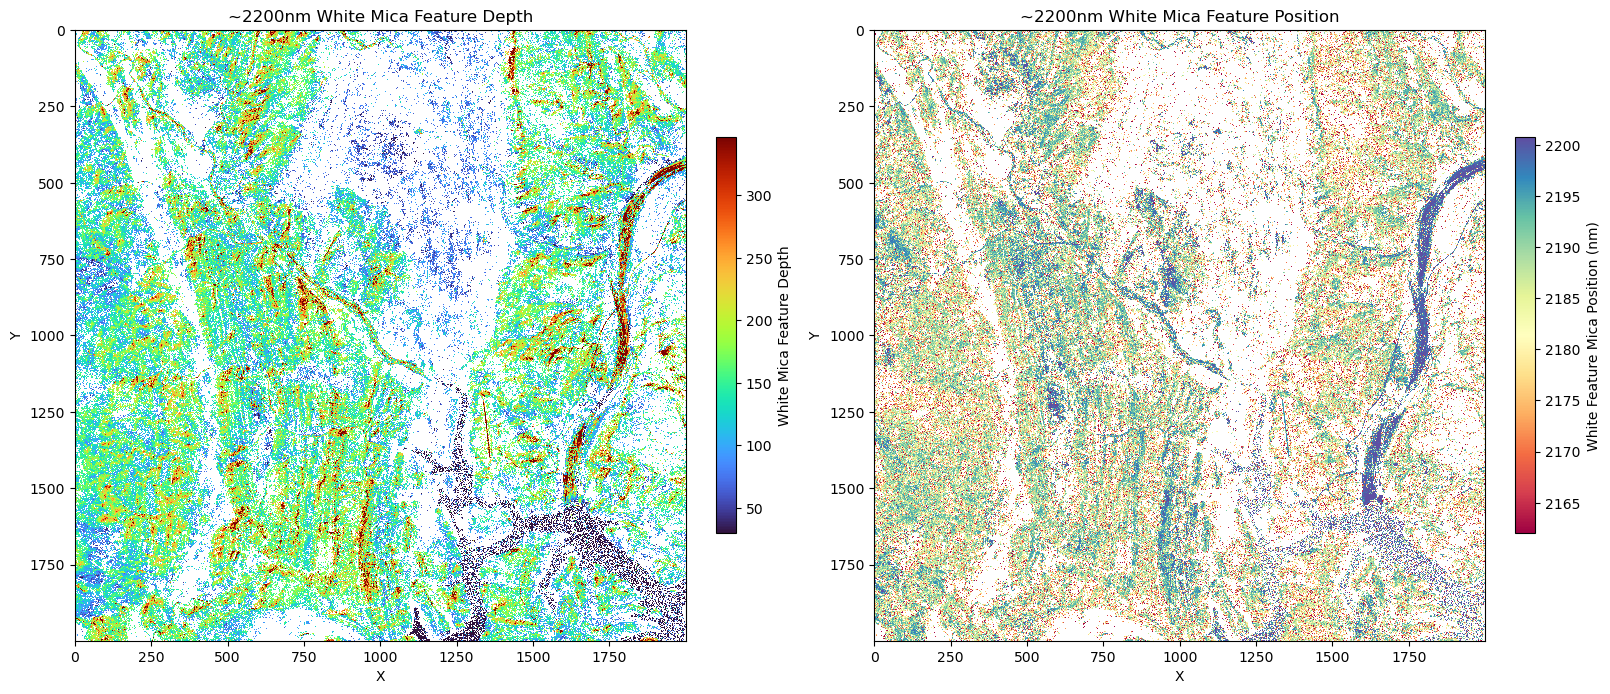

In [76]:
# read a 1500 by 1500 pixel window from the white mica output
read_win = Window(4000, 1500, 2000, 2000)
with rasterio.open(mica_fn,'r') as src:
  win_depth, win_pos = src.read(window=read_win)  
  # mask the arrays for plotting 
  win_depth = np.ma.masked_array(win_depth, win_depth==src.nodata)
  win_pos = np.ma.masked_array(win_pos, win_pos==src.nodata)

# plot the two products side by side for a window
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(16,8),constrained_layout=True)
depth_plt = ax0.imshow(win_depth, interpolation='nearest', cmap='turbo',
  vmin=np.percentile(win_depth.data[~win_depth.mask],2), vmax=np.percentile(win_depth.data[~win_depth.mask],98))
pos_plt = ax1.imshow(win_pos, interpolation='nearest', cmap='Spectral',
  vmin=np.percentile(win_pos.data[~win_pos.mask],2), vmax=np.percentile(win_pos.data[~win_pos.mask],98))
fig.colorbar(depth_plt, ax=ax0, shrink=0.5, label='White Mica Feature Depth')
fig.colorbar(pos_plt, ax=ax1, shrink=0.5, label='White Feature Mica Position (nm)')
ax0.set(title='~2200nm White Mica Feature Depth', ylabel='Y', xlabel='X')
ax1.set(title='~2200nm White Mica Feature Position', ylabel='Y', xlabel='X')
plt.savefig(r'../assets/notebook_4_image.png', dpi=70, bbox_inches='tight')
plt.show()